In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import all the libraries

In [2]:
from fastai import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

ModuleNotFoundError: No module named 'fastai.transforms'

check if cuda is available

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

set the path to dataset

In [6]:
PATH = "data/dogscats"
sz = 224

take a peek at the pictures

In [7]:
os.listdir(PATH)

['train', 'sample', 'models', 'valid', 'tmp', 'test1']

In [8]:
os.listdir(f"{PATH}/valid")

['cats', 'dogs']

In [9]:
files = os.listdir(f"{PATH}/valid/cats")[:5]
files

['cat.4282.jpg',
 'cat.6314.jpg',
 'cat.5377.jpg',
 'cat.2647.jpg',
 'cat.6183.jpg']

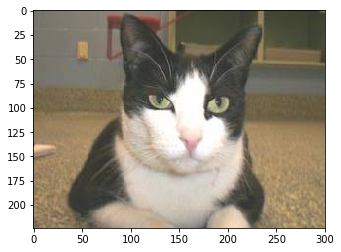

In [10]:
img = plt.imread(f"{PATH}/valid/cats/{files[0]}")
plt.imshow(img)

image raw data

In [11]:
img.shape

(224, 300, 3)

In [12]:
len(files)

5

### quick start: first model

using pre-trained model, resnet34

In [13]:
arch = resnet34

In [14]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [15]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [16]:
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.047441   0.028866   0.9875    
    1      0.042238   0.024759   0.991                         



[0.02475869382917881, 0.991]

analyzing result

In [17]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

the labels above are..

In [18]:
data.classes

['cats', 'dogs']

cats = 0, dogs = 1

to check the prediction for validation set

In [19]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

the predictions are in log scale

In [20]:
log_preds[:5]

array([[ -0.00001, -11.10783],
       [ -0.00007,  -9.5855 ],
       [ -0.     , -13.59621],
       [ -0.00952,  -4.65906],
       [ -0.00001, -11.85348]], dtype=float32)

from log probabilities to 0 or 1

In [21]:
preds = np.argmax(log_preds, axis=1)

In [22]:
probs = np.exp(log_preds[:,1])

### analyzing results: looking at pictures

#### functions to view the data conveniently

In [23]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y)==is_correct)

In [24]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [25]:
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(f"{PATH}/{ds.fnames[idx]}"))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

In [26]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

#### a few correct labels at random

Correctly classified


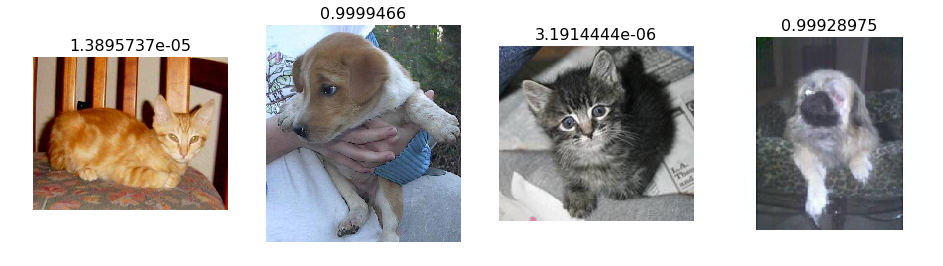

In [27]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

#### a few incorrect labels at random

Incorrectly classified


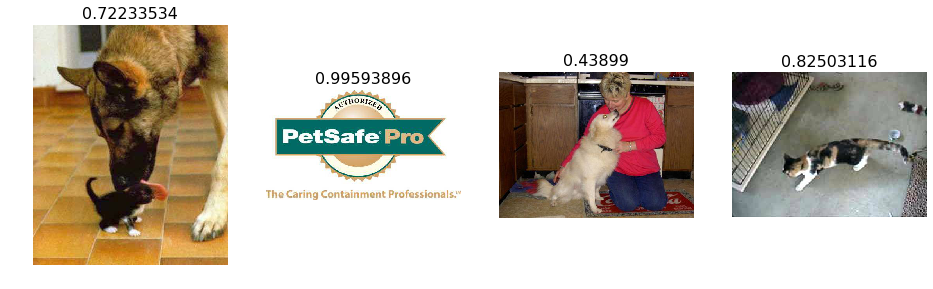

In [28]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

#### most correct

Most correct cats


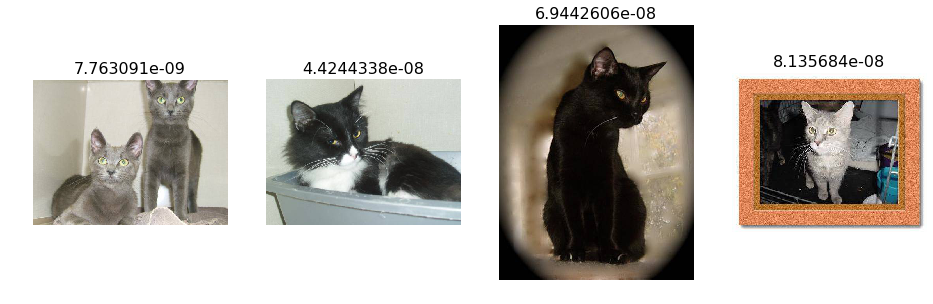

In [29]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


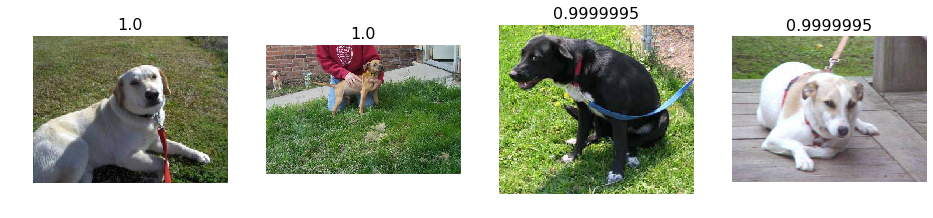

In [30]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

#### most incorrect

Most incorrect cats


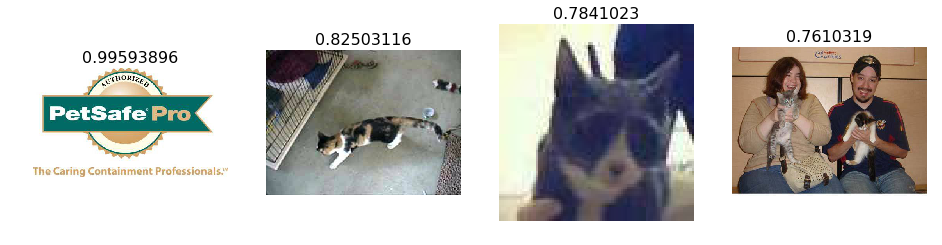

In [31]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


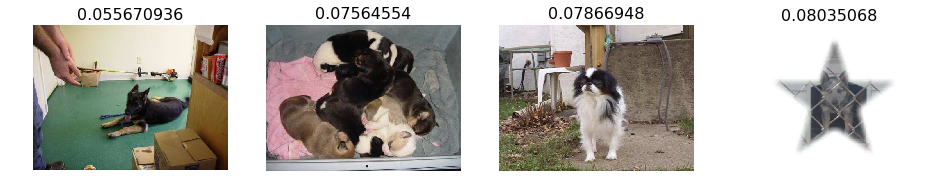

In [32]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

#### most uncertain

Most uncertain predictions


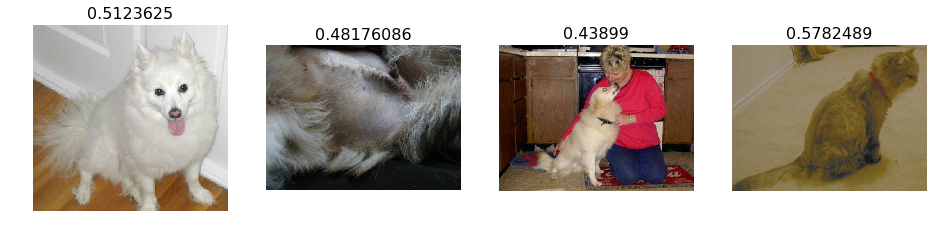

In [33]:
most_uncertain = np.argsort(np.abs(probs-0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

### choosing a learning rate

In [34]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [35]:
lrf = learn.lr_find()

 83%|████████▎ | 299/360 [00:02<00:00, 123.51it/s, loss=0.219]


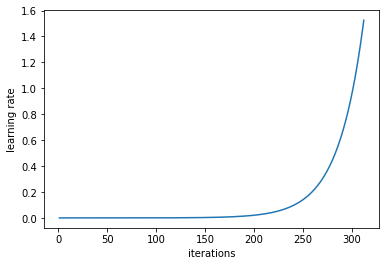

In [36]:
learn.sched.plot_lr()

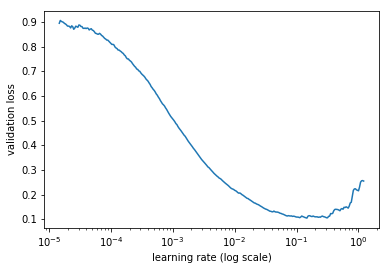

In [37]:
learn.sched.plot()

### improving the model

#### data augmentation

In [39]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [42]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [43]:
ims = np.stack([get_augs() for i in range(6)])

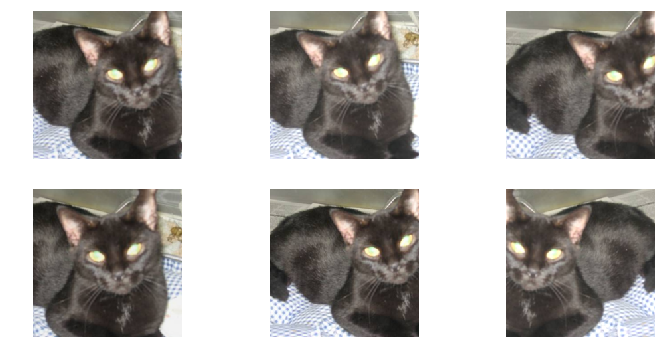

In [44]:
plots(ims, rows=2)

Include the augmentation in a new ```data``` object

In [45]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [46]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.044961   0.029332   0.9895    



[0.02933231794834137, 0.9895]

In [47]:
learn.precompute=False

In [48]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.046081   0.024926   0.9915    
    1      0.046142   0.026195   0.991                        
    2      0.044455   0.02467    0.989                        



[0.02467010550200939, 0.989]